In [1]:
print('good to go')

good to go


In [2]:
!pip install s3fs



In [3]:
!pip install rasterio



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 105.2 MB/s eta 0:00:0000:0100:01


In [4]:

!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 104.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 102.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 128.0 MB/s eta 0:00:00


In [5]:
import rasterio
import matplotlib.pyplot as plt
import json
import geopandas as gpd
import s3fs

def load_image(image_s3_uri):
    """Load an image from S3 using rasterio."""
    fs = s3fs.S3FileSystem()
    with fs.open(image_s3_uri, 'rb') as f:
        src = rasterio.open(f)
    return src

def load_annotations(annotation_s3_uri, image_filename):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    for img in data['images']:
        if img['file_name'] == image_filename:
            return img['annotations']
    return None




In [6]:
def convert_to_geojson(data):
    """
    Converts a list of dictionaries in the specified format to GeoJSON.
    
    Args:
        data: A list of dictionaries containing 'class' and 'segmentation' keys.
    
    Returns:
        A GeoJSON feature collection.
    """
    features = []
    for item in data:
        polygon = []
        for i in range(0, len(item['segmentation']), 2):
            polygon.append([item['segmentation'][i], item['segmentation'][i+1]])
        features.append({
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [polygon]
            },
            "properties": {"class": item['class']}
        })
    return {"type": "FeatureCollection", "features": features}



In [7]:
def visualize_image_with_annotations(image_s3_uri, annotation_s3_uri):
    """Visualize an image with its annotations from S3."""
    # Load image
    src = load_image(image_s3_uri)
    
    # Extract the filename from the S3 URI
    image_filename = image_s3_uri.split('/')[-1]
    
    # Load annotations
    annotations = load_annotations(annotation_s3_uri, image_filename)
    
    if not annotations:
        print(f"No annotations found for {image_filename}")
        return
    
    # Convert annotations to GeoJSON
    geojson_data = convert_to_geojson(annotations)
    
    # Convert GeoJSON to GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(geojson_data)
    
    # Plot the raster image and the annotations
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot raster
    ax.imshow(src.read(2), cmap="gray")
    ax.set_title(f"Image and Annotations for {image_filename}")
    
    # Plot field segmentation
    gdf.boundary.plot(ax=ax, edgecolor="red")
    
    plt.show()



In [8]:
# Load Json
train_annotation_s3_uri = 's3://solafune/train_annotation.json'


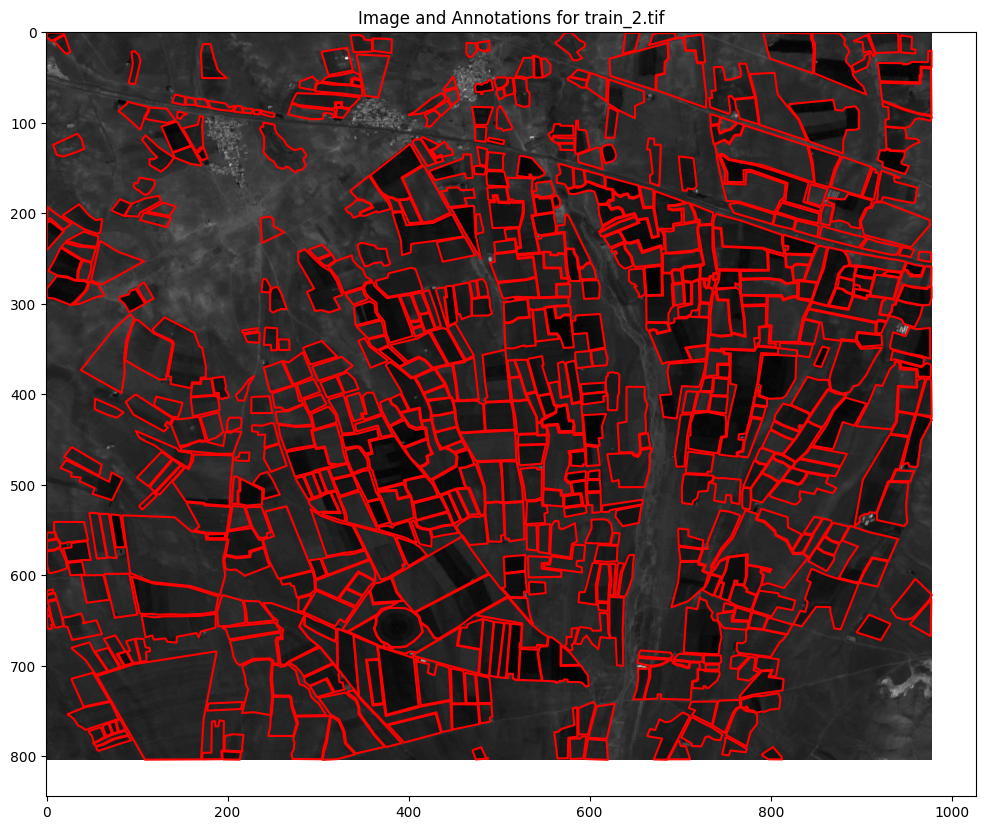

In [9]:
#Sample Image
train_image_s3_uri = 's3://solafune/train_images/images/train_2.tif'
visualize_image_with_annotations(train_image_s3_uri, train_annotation_s3_uri)

In [10]:
import numpy as np
from shapely.geometry import Polygon, mapping
from PIL import Image, ImageDraw

def create_segmentation_mask(image_shape, annotations):
    """
    Create a segmentation mask for an image based on the annotations.
    
    Args:
        image_shape: Tuple of the image dimensions (height, width).
        annotations: List of annotations with 'segmentation' data.
    
    Returns:
        A numpy array representing the segmentation mask.
    """
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    for annotation in annotations:
        segmentation = annotation['segmentation']
        polygon_points = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
        poly = Polygon(polygon_points)
        
        # Create a mask using PIL
        mask_img = Image.new('L', (image_shape[1], image_shape[0]), 0)
        draw = ImageDraw.Draw(mask_img)
        draw.polygon(polygon_points, outline=1, fill=1)
        mask = np.maximum(mask, np.array(mask_img))
    
    return mask

def load_image_and_mask(image_s3_uri, annotation_s3_uri, image_filename):
    """Load an image and its corresponding mask."""
    # Load the image
    src = load_image(image_s3_uri)
    
    # Load the annotations
    annotations = load_annotations(annotation_s3_uri, image_filename)
    
    # Create the segmentation mask
    mask = create_segmentation_mask((src.height, src.width), annotations)
    
    return src.read([1, 2, 3]), mask  # Using RGB channels




In [11]:
# Example usage
train_image_s3_uri = 's3://solafune/train_images/images/train_1.tif'
image_filename = 'train_2.tif'
image, mask = load_image_and_mask(train_image_s3_uri, train_annotation_s3_uri, image_filename)

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

Image shape: (3, 803, 1008)
Mask shape: (803, 1008)


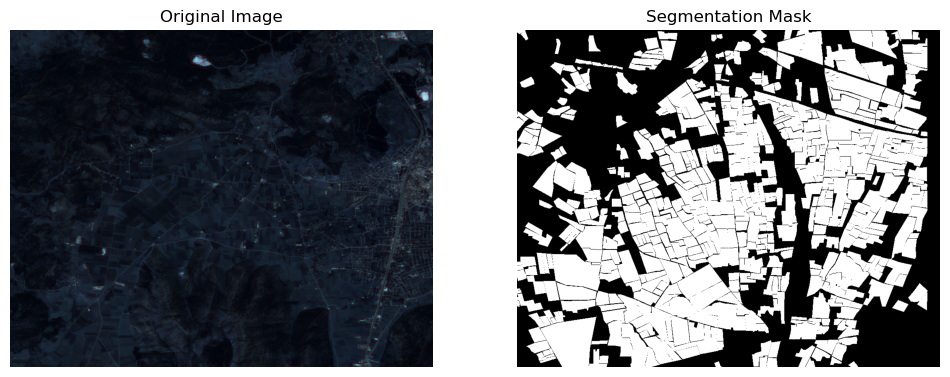

In [12]:

def plot_image_and_mask(image, mask):
    """Plot the image and its corresponding mask side by side."""
    # Ensure the image is in the correct range
    if np.max(image) > 1:
        image = image / np.max(image)  # Normalize to [0, 1] if necessary

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the original image
    axes[0].imshow(np.moveaxis(image, 0, -1))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot the mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Segmentation Mask')
    axes[1].axis('off')

    plt.show()

# Example usage
plot_image_and_mask(image, mask)


## Creating a Model Architecture

### U-Net Architecture Overview

The U-Net architecture is a convolutional neural network designed for image segmentation tasks. It consists of two main parts:

1. **Encoder (Contracting Path)**:
   - **Purpose**: Captures context and features at different spatial resolutions.
   - **Structure**: Composed of repeated blocks of two convolutional layers followed by batch normalization and ReLU activation. Each block is followed by max-pooling, which reduces the spatial dimensions of the feature maps.

2. **Decoder (Expanding Path)**:
   - **Purpose**: Reconstructs the image from the encoded features while retaining fine details.
   - **Structure**: Each block starts with upsampling (using bilinear interpolation or transposed convolutions) followed by concatenation with the corresponding feature map from the encoder. This is followed by two convolutional layers, batch normalization, and ReLU activation.

3. **Final Layer**:
   - **Purpose**: Produces the final segmentation map.
   - **Structure**: A single convolutional layer with a 1x1 kernel that reduces the number of channels to the desired output (e.g., 1 for binary segmentation).


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # for padding issues
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



In [14]:
# Create the model
model = UNet(n_channels=3, n_classes=1)  # Assuming binary segmentation


## Training


In [15]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision.transforms as T  # This is the missing import


In [16]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, annotation_paths):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_s3_uri = self.image_paths[idx]
        annotation_s3_uri = self.annotation_paths[idx]
        image_filename = image_s3_uri.split('/')[-1]
        
        # Load image and mask
        image, mask = load_image_and_mask(image_s3_uri, annotation_s3_uri, image_filename)
        
        # Debugging: Print the initial shape of the image
        #print(f"Initial image shape: {image.shape}")
        
        # Ensure the image is in [height, width, channels] format
        if len(image.shape) == 3 and image.shape[0] == 3:
            image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        
        # Debugging: Print the shape after rearranging
        #print(f"Shape after rearranging: {image.shape}")
        
        # Convert the image to uint8 and ensure shape is [height, width, channels]
        if image.max() > 1:
            image = (image / image.max() * 255).astype(np.uint8)
        else:
            image = (image * 255).astype(np.uint8)
        
        # Debugging: Print the shape before converting to PIL
        #print(f"Final image shape before PIL conversion: {image.shape}")
        
        # Convert to PIL Images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)
        
        # Determine the max size for padding
        max_height = 1008  # Example based on your output
        max_width = 1008   # Example based on your output
        
        # Pad image and mask
        image = TF.pad(image, padding=[0, 0, max_width - image.width, max_height - image.height], padding_mode='constant')
        mask = TF.pad(mask, padding=[0, 0, max_width - mask.width, max_height - mask.height], padding_mode='constant')
        
        # Transform image and mask to tensors
        transform = T.Compose([T.ToTensor()])
        image = transform(image).float()  # Convert image to tensor and ensure float32
        
        mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)  # Ensure the mask is float32
        
        return image, mask


In [17]:
import s3fs

# S3 bucket path for training images
train_images_s3_uri = 's3://solafune/train_images/images/'

# Initialize S3 filesystem
fs = s3fs.S3FileSystem()

# List all files in the train_images directory
train_image_paths = fs.ls(train_images_s3_uri)

# Filter out only .tif files
train_image_paths = [f"s3://{path}" for path in train_image_paths if path.endswith('.tif')]

# Display the paths to confirm
print(f"Found {len(train_image_paths)} training images.")




Found 50 training images.


In [18]:
train_annotation_paths = ['s3://solafune/train_annotation.json'] * len(train_image_paths)

# Create the dataset
train_dataset = SegmentationDataset(train_image_paths, train_annotation_paths)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)


In [19]:
# import torch.nn as nn
# import torch.optim as optim

# # Instantiate the model
# model = UNet(n_channels=3, n_classes=1)

# # Define loss function and optimizer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


In [20]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import time

# Training function with a progress bar
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Initialize the progress bar
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for batch_idx, (images, masks) in pbar:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
            # Update the progress bar with the current batch loss
            pbar.set_postfix({
                'Batch': f'{batch_idx + 1}/{len(train_loader)}',
                'Loss': f'{loss.item():.4f}'
            })
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}\n")
        
    print("Training complete!")

# Define the model, criterion, and optimizer
model = UNet(n_channels=3, n_classes=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
num_epochs = 10
train_model(model, train_loader, criterion, optimizer, num_epochs, device)


Epoch 1/10:  16%|█▌        | 4/25 [00:20<01:51,  5.30s/batch, Batch=4/25, Loss=0.3819]/tmp/ipykernel_17737/1764646682.py:31: RuntimeWarning: invalid value encountered in cast
  image = (image * 255).astype(np.uint8)
Epoch 1/10: 100%|██████████| 25/25 [02:10<00:00,  5.24s/batch, Batch=25/25, Loss=0.5210]



Epoch [1/10], Loss: 0.4500



Epoch 2/10: 100%|██████████| 25/25 [02:04<00:00,  4.97s/batch, Batch=25/25, Loss=0.2904]



Epoch [2/10], Loss: 0.3789



Epoch 3/10: 100%|██████████| 25/25 [02:02<00:00,  4.89s/batch, Batch=25/25, Loss=0.2876]



Epoch [3/10], Loss: 0.3809



Epoch 4/10: 100%|██████████| 25/25 [02:02<00:00,  4.89s/batch, Batch=25/25, Loss=0.4685]



Epoch [4/10], Loss: 0.3821



Epoch 5/10: 100%|██████████| 25/25 [02:02<00:00,  4.90s/batch, Batch=25/25, Loss=0.3559]



Epoch [5/10], Loss: 0.3651



Epoch 6/10: 100%|██████████| 25/25 [02:00<00:00,  4.81s/batch, Batch=25/25, Loss=0.3037]



Epoch [6/10], Loss: 0.3699



Epoch 7/10: 100%|██████████| 25/25 [02:00<00:00,  4.82s/batch, Batch=25/25, Loss=0.4924]



Epoch [7/10], Loss: 0.3950



Epoch 8/10: 100%|██████████| 25/25 [02:00<00:00,  4.81s/batch, Batch=25/25, Loss=0.3142]



Epoch [8/10], Loss: 0.3601



Epoch 9/10: 100%|██████████| 25/25 [02:00<00:00,  4.83s/batch, Batch=25/25, Loss=0.5261]



Epoch [9/10], Loss: 0.3789



Epoch 10/10: 100%|██████████| 25/25 [01:59<00:00,  4.80s/batch, Batch=25/25, Loss=0.2620]


Epoch [10/10], Loss: 0.3616

Training complete!


In [35]:
import rasterio
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as T

class TestSegmentationDataset(Dataset):
    def __init__(self, image_paths, selected_channels=[0, 1, 2]):  # Default to the first 3 channels
        self.image_paths = image_paths
        self.selected_channels = selected_channels
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_s3_uri = self.image_paths[idx]
        
        # Load image using rasterio and read it as a NumPy array
        with rasterio.open(image_s3_uri) as src:
            image = src.read()  # This returns an array with shape (channels, height, width)
        
        # Select the desired channels
        if len(image.shape) == 3:
            image = image[self.selected_channels, :, :]  # Select specific channels
        
        # Ensure the image is in [height, width, channels] format
        if len(image.shape) == 3:
            image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        
        # Convert the image to uint8 and ensure shape is [height, width, channels]
        if image.max() > 1:
            image = (image / image.max() * 255).astype(np.uint8)
        else:
            image = (image * 255).astype(np.uint8)
        
        # Convert to PIL Image
        image = Image.fromarray(image)
        
        # Transform image to tensor
        transform = T.Compose([T.ToTensor()])
        image = transform(image).float()  # Convert image to tensor and ensure float32
        
        return image, image_s3_uri.split('/')[-1]  # Return the image and its filename


In [36]:
# Define the test image paths (S3 URIs)
test_image_paths = [
    's3://solafune/test_images/images/test_0.tif',
    's3://solafune/test_images/images/test_1.tif',
    # Add more test images as needed
]

# Create the test dataset
test_dataset = TestSegmentationDataset(test_image_paths)

# Create the DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set batch_size and shuffle as needed


In [37]:
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for images, image_filenames in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Apply sigmoid for binary mask prediction
            
            # Move predictions to CPU and convert to numpy
            preds = preds.cpu().numpy()
            predictions.append(preds)
            filenames.extend(image_filenames)
    
    return predictions, filenames






In [38]:
# Generate predictions
# Generate predictions
# Create the test dataset with the first three channels
test_dataset = TestSegmentationDataset(test_image_paths, selected_channels=[0, 1, 2])

In [39]:
# Generate predictions
test_predictions, test_filenames = predict(model, test_loader, device)

# Print the filenames and shape of the first prediction to verify
print(f"Filenames: {test_filenames}")
print(f"Shape of the first prediction: {test_predictions[0].shape}")


Filenames: ['test_0.tif', 'test_1.tif']
Shape of the first prediction: (1, 1, 802, 1171)


/tmp/ipykernel_17737/241442285.py:34: RuntimeWarning: invalid value encountered in cast
  image = (image * 255).astype(np.uint8)


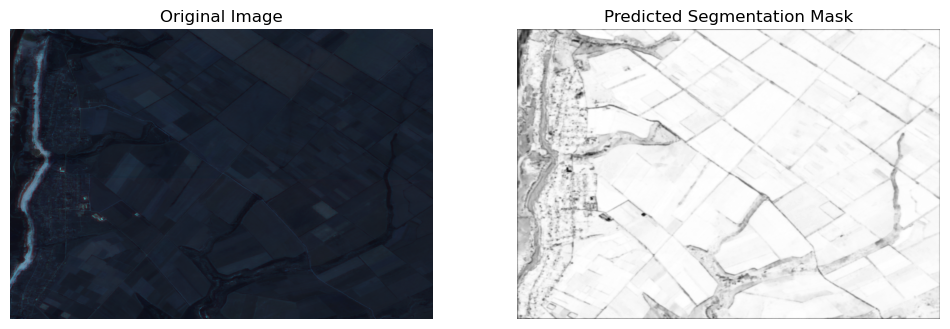

In [40]:
import matplotlib.pyplot as plt

def plot_prediction(image, prediction):
    """Plot the original image and its predicted segmentation mask."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the original image
    axes[0].imshow(np.moveaxis(image.numpy(), 0, -1))  # Move channels to the last dimension for plotting
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot the predicted mask
    axes[1].imshow(prediction[0, 0], cmap='gray')  # Assuming binary mask prediction
    axes[1].set_title('Predicted Segmentation Mask')
    axes[1].axis('off')

    plt.show()

# Visualize the first prediction
image, _ = next(iter(test_loader))
plot_prediction(image[0], test_predictions[0])

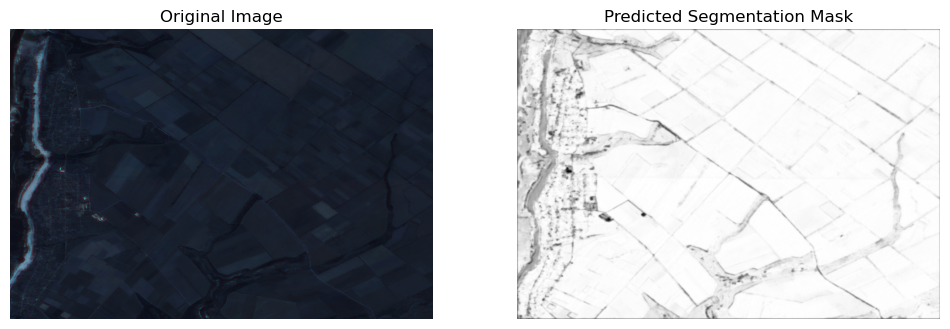

In [34]:
# Train the model
num_epochs = 10
train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch 1/10:  32%|███▏      | 8/25 [00:40<01:28,  5.18s/batch, Batch=8/25, Loss=0.3492]/tmp/ipykernel_17737/1764646682.py:31: RuntimeWarning: invalid value encountered in cast
  image = (image * 255).astype(np.uint8)
Epoch 1/10: 100%|██████████| 25/25 [02:03<00:00,  4.95s/batch, Batch=25/25, Loss=0.2640]



Epoch [1/10], Loss: 0.3533



Epoch 2/10: 100%|██████████| 25/25 [02:02<00:00,  4.91s/batch, Batch=25/25, Loss=0.2869]



Epoch [2/10], Loss: 0.3685



Epoch 3/10: 100%|██████████| 25/25 [02:02<00:00,  4.91s/batch, Batch=25/25, Loss=0.2540]



Epoch [3/10], Loss: 0.3466



Epoch 4/10: 100%|██████████| 25/25 [02:01<00:00,  4.86s/batch, Batch=25/25, Loss=0.3065]



Epoch [4/10], Loss: 0.3402



Epoch 5/10: 100%|██████████| 25/25 [02:00<00:00,  4.82s/batch, Batch=25/25, Loss=0.2789]



Epoch [5/10], Loss: 0.3534



Epoch 6/10: 100%|██████████| 25/25 [01:59<00:00,  4.80s/batch, Batch=25/25, Loss=0.5608]



Epoch [6/10], Loss: 0.3705



Epoch 7/10: 100%|██████████| 25/25 [01:59<00:00,  4.78s/batch, Batch=25/25, Loss=0.3131]



Epoch [7/10], Loss: 0.3391



Epoch 8/10: 100%|██████████| 25/25 [01:59<00:00,  4.79s/batch, Batch=25/25, Loss=0.2931]



Epoch [8/10], Loss: 0.3533



Epoch 9/10: 100%|██████████| 25/25 [02:02<00:00,  4.91s/batch, Batch=25/25, Loss=0.4042]



Epoch [9/10], Loss: 0.3320



Epoch 10/10: 100%|██████████| 25/25 [02:03<00:00,  4.92s/batch, Batch=25/25, Loss=0.2439]


Epoch [10/10], Loss: 0.3629

Training complete!
